## Natural Language Processing - Hoppy Trails
### Project: Crowdsourced Beer recommendation system

#### Please note: Google Colab were used for this project, so some code (i.e. pip install, file uploading) may not be relevant if you try to run this on Jupyter Notebook.

### author:
*   Dameli Aziken

# Step I : Web Scrapping

# Get the list of top 50 beers and their URLs

In [1]:
import requests
from bs4 import BeautifulSoup

# URL of the website you want to scrape
url = "https://ratebeer.com/beer/top-50/"

# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all the beer name links in the table
beer_links = soup.select('td a[href^="/beer/"]')

# Extract beer names and their corresponding URLs
beers = []
for link in beer_links:
    name = link.text.strip()
    href = link['href']
    if name != '' and 'Top ' not in name:
        beers.append({'name': name, 'url': f"https://ratebeer.com{href}"})

beer_ls_50 = []

# Print the results
for beer in beers:
    # print(f"Beer: {beer['name']}, URL: {beer['url']}")
    beer_ls_50.append(beer['url'])

beer_ls_50

['https://ratebeer.com/beer/toppling-goliath-kentucky-brunch/166019/',
 'https://ratebeer.com/beer/narke-kaggen-stormaktsporter/58057/',
 'https://ratebeer.com/beer/westvleteren-12/4934/',
 'https://ratebeer.com/beer/toppling-goliath-mornin-delight/151817/',
 'https://ratebeer.com/beer/russian-river-pliny-the-younger/43181/',
 'https://ratebeer.com/beer/alesmith-speedway-stout-bourbon-barrel-aged/28173/',
 'https://ratebeer.com/beer/bells-black-note-stout/71826/',
 'https://ratebeer.com/beer/founders-cbs-canadian-breakfast-stout/98973/',
 'https://ratebeer.com/beer/perennial-abraxas-barrel-aged/191962/',
 'https://ratebeer.com/beer/alesmith-speedway-stout-barrel-aged-vietnamese-coffee/296243/',
 'https://ratebeer.com/beer/alesmith-speedway-stout/14232/',
 'https://ratebeer.com/beer/hill-farmstead-ann/175070/',
 'https://ratebeer.com/beer/trappistes-rochefort-10/2360/',
 'https://ratebeer.com/beer/cigar-city-hunahpus-imperial-stout/97078/',
 'https://ratebeer.com/beer/founders-kbs-kentu

# Retrieve reviews for top 50 beers from the review page URLs (3-pages * 15 reviews/page) ~ 2k reviews

In [2]:
# Function to expand all the 'Show more' buttons on the review page
def expand_all_reviews(driver):
    try:
        # Find all "Show more" buttons using the correct XPath
        see_more_buttons = driver.find_elements(By.XPATH, '//button/span[contains(@class, "MuiButton-label") and text()="Show more"]')
        for button in see_more_buttons:
            # Scroll the button into view
            driver.execute_script("arguments[0].scrollIntoView(true);", button)
            # Add a small delay to allow the page to settle after scrolling
            time.sleep(0.5)
            # Click the parent button element
            parent_button = button.find_element(By.XPATH, './..')
            driver.execute_script("arguments[0].click();", parent_button)
            # Add a small delay after clicking to allow content to expand
            time.sleep(0.5)
        print(f"Expanded {len(see_more_buttons)} 'Show more' buttons")
    except Exception as e:
        print(f"Error expanding reviews: {e}")

In [ ]:
!pip install selenium
!pip install webdriver_manager_chrome

ERROR: Could not find a version that satisfies the requirement webdriver_manager_chrome (from versions: none)
ERROR: No matching distribution found for webdriver_manager_chrome


In [4]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import modules
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize the WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=chrome_options)

# Set up an explicit wait
wait = WebDriverWait(driver, 500)

# Initialize a list to store data
data = []

# Loop over each beer URL in your list
for beer_url in beer_ls_50:
    # Navigate to the beer's main page
    driver.get(beer_url)

    # Wait until the product name is present
    wait.until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn text-500 colorized__WrappedComponent-hrwcZr hwjOn mt-3 MuiTypography-h4")]')))

    # Get the product name
    try:
        product_name = driver.find_element(By.XPATH, '//div[@class="user-header"]//h1').text.strip()
    except:
        product_name = ''

    print(f"Scraping reviews for: {beer_url}")

    # Initialize page number
    page_number = 1

    # In your main loop, before extracting reviews:
    while True:
        # Wait until the reviews are loaded
        wait.until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn colorized__WrappedComponent-hrwcZr hwjOn BeerReviewListItem___StyledText-kMbsdb gCtEHi pre-wrap MuiTypography-body1")]')))

        # Expand all reviews
        expand_all_reviews(driver)

        # Get all the reviews on the current page
        reviews = driver.find_elements(By.XPATH, '//div[contains(@class, "px-4 fj-s f-wrap")]')

        if not reviews:
            break

        for review in reviews:
            # Extract user rating and review text
            try:
                user_rating = review.find_element(By.XPATH, './/span[contains(@class, "MuiTypography-root Text___StyledTypographyTypeless-bukSfn pzIrn text-500 colorized__WrappedComponent-hrwcZr bRPQdN MuiTypography-subtitle1")]').text.strip()
            except:
                user_rating = ''
            try:
                product_review_element = review.find_element(By.XPATH, './/div[contains(@class, "BeerReviewListItem___StyledText")]')
                # Handle any encoding issues
                product_review = product_review_element.text.strip().encode('utf-8', 'ignore').decode('utf-8', 'ignore')
            except:
                product_review = ''

            data.append({
                'product_name': beer_url,
                'user_rating': user_rating,
                'product_review': product_review
            })

        # Check if we've reached the desired number of pages
        if page_number >= 3:
            print(f"Reached page limit.")
            break

        # Check if there's a banner blocking the 'Next' button
        try:
            banner = driver.find_element(By.XPATH, '//div[contains(@class, "RateBeerBestBanner___StyledDiv")]')
            if banner.is_displayed():
                # Close the banner if it has a close button
                try:
                    close_button = banner.find_element(By.XPATH, './/button')
                    close_button.click()
                    print("Banner closed.")
                except:
                    # If there's no close button, hide the banner using JavaScript
                    driver.execute_script("arguments[0].style.display = 'none';", banner)
                    print("Banner hidden via JavaScript.")
        except:
            pass  # Banner not present

        # Check if there's a 'next' button for reviews
        try:
            next_button = driver.find_element(By.XPATH, '//button[contains(@aria-label, "Next page")]')
            if not next_button.is_enabled():
                # No more pages
                break
            else:
                # Scroll to the 'Next' button to ensure it's in view
                driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
                time.sleep(1)  # Small delay
                # Click the 'Next' button using JavaScript to bypass interception
                driver.execute_script("arguments[0].click();", next_button)
                page_number += 1
                print(f"Moving to page {page_number}.")
                # Wait for the next page to load
                time.sleep(2)
                # Wait until the first review becomes stale
                wait.until(EC.staleness_of(reviews[0]))
        except Exception as e:
            print(f"No next button found or cannot click next on page {page_number} for {product_name}: {e}")
            break

# Close the WebDriver
driver.quit()

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Save reviews
df.to_csv("RateBeer Scraped Data.csv", index=False)

Scraping reviews for: https://ratebeer.com/beer/toppling-goliath-kentucky-brunch/166019/
Expanded 15 'Show more' buttons
Moving to page 2.
Expanded 14 'Show more' buttons
Moving to page 3.
Expanded 13 'Show more' buttons
Reached page limit.
Scraping reviews for: https://ratebeer.com/beer/narke-kaggen-stormaktsporter/58057/
Expanded 16 'Show more' buttons
Moving to page 2.
Expanded 15 'Show more' buttons
Moving to page 3.
Expanded 15 'Show more' buttons
Reached page limit.
Scraping reviews for: https://ratebeer.com/beer/westvleteren-12/4934/
Expanded 14 'Show more' buttons
Moving to page 2.
Expanded 15 'Show more' buttons
Moving to page 3.
Expanded 10 'Show more' buttons
Reached page limit.
Scraping reviews for: https://ratebeer.com/beer/toppling-goliath-mornin-delight/151817/
Expanded 15 'Show more' buttons
Moving to page 2.
Expanded 14 'Show more' buttons
Moving to page 3.
Expanded 13 'Show more' buttons
Reached page limit.
Scraping reviews for: https://ratebeer.com/beer/russian-river

In [6]:
# Final data
results = pd.DataFrame(beers).merge(df, left_on = 'url', right_on = 'product_name')
final = results[['name', 'user_rating', 'product_review']].drop_duplicates()
final.to_csv("RateBeer_Data.csv", index=False)

-----------End of Task A -----------

# Analysis

In [ ]:
!pip install nltk

In [7]:
import csv
import nltk
import re
import spacy
import pandas as pd
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from nltk.corpus import reuters, wordnet, stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rate_beer.csv to rate_beer (1).csv


In [12]:
rate_beer_org = pd.read_csv("RateBeer_Data.csv" ) #, encoding='latin1'

In [ ]:
#we have to translate all german, chinese or reviews written in any other language into English - run just one - otherwise you might have to resyart the kernel
!pip install langdetect googletrans==4.0.0-rc1

In [13]:
rate_beer_org.head()
len(rate_beer_org)

2250

In [14]:
rate_beer_org.head()

,name,user_rating,product_review
0,Toppling Goliath Kentucky Brunch,3.3,"You need personal informations from companies,..."
1,Toppling Goliath Kentucky Brunch,4.5,"Bottle after MBCC 2024. Black colour, malty ar..."
2,Toppling Goliath Kentucky Brunch,4.3,Thank you for sharing this Chris - Black with ...
3,Toppling Goliath Kentucky Brunch,4.7,"Boxed beer at home, proper glassware. Pitch bl..."
4,Toppling Goliath Kentucky Brunch,4.9,"From backlog. (As 2018 Vintage) 0,3 litre Bott..."


# Data Cleaning

In [15]:
#let's take only the rows which have reviews
df= rate_beer_org[rate_beer_org['product_review'].notna() & (rate_beer_org['product_review'].str.strip()!='')]
len(df)

2250

In [ ]:
!pip install deep-translator

In [19]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 3.9 MB/s eta 0:00:00m-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=422dccdffab8bd99a28450f62c92739703663ca5c7a919f13c3b15c4b6dd75f8
  Stored in directory: /Users/dameliaziken/Library/Caches/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [20]:
from deep_translator import GoogleTranslator
import pandas as pd
from langdetect import detect

# Initialize GoogleTranslator
translator = GoogleTranslator(source='auto', target='en')

# Function to detect language and translate to English using deep-translator
def detect_and_translate_deep(text):
    try:
        # Detect the language
        detected_lang = detect(text)
        # If it's not already English, translate it using deep-translator
        if detected_lang != 'en':
            return translator.translate(text)
        else:
            return text
    except Exception as e:
        return f"Error: {str(e)}"

In [21]:
# Apply the detect and translate function to the 'reviews' column
rate_beer_org['product_review'] = rate_beer_org['product_review'].apply(detect_and_translate_deep)

In [22]:
from copy import deepcopy
# Display the DataFrame with the new translated column
print(rate_beer_org)
df = rate_beer_org.copy(deep=True)
df.rename(columns={'name': 'product_name'}, inplace=True)

                                  name  user_rating  \
0     Toppling Goliath Kentucky Brunch          3.3   
1     Toppling Goliath Kentucky Brunch          4.5   
2     Toppling Goliath Kentucky Brunch          4.3   
3     Toppling Goliath Kentucky Brunch          4.7   
4     Toppling Goliath Kentucky Brunch          4.9   
...                                ...          ...   
2245      Stone Imperial Russian Stout          4.4   
2246      Stone Imperial Russian Stout          4.8   
2247      Stone Imperial Russian Stout          4.2   
2248      Stone Imperial Russian Stout          4.1   
2249      Stone Imperial Russian Stout          3.6   

                                         product_review  
0     You need personal informations from companies,...  
1     Bottle after MBCC 2024. Black colour, malty ar...  
2     Thank you for sharing this Chris - Black with ...  
3     Boxed beer at home, proper glassware. Pitch bl...  
4     From backlog. (As 2018 Vintage) 0,3 litre B

In [23]:
#check if translation worked
csv_file_path = 'translated.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
df.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

ModuleNotFoundError: No module named 'google'

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [27]:
import re

# Define your custom stopwords list manually
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
    'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
    'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
    'with', 'about', 'against', 'between', 'into', 'through', 'during', 
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 
    'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 
    'don', 'should', 'now'
])

# Function to remove stopwords and tokenize
def remove_stopwords_and_tokenize(text):
    # Handle non-string (float or NaN) values by converting them to empty strings
    if not isinstance(text, str):
        text = ''
    # Preprocess: Replace hyphens between words with underscores to preserve hyphenated words
    text = re.sub(r'\b(\w+)-(\w+)\b', r'\1_\2', text.lower())  # Convert text to lowercase and replace hyphenated words
    # Tokenize using regex to handle numbers followed by '%'
    tokens = re.findall(r'\b\d+%|\w+\b', text)  # Use regex to treat numbers with % as a single token
    # Remove stopwords and keep only relevant tokens
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Example usage
sample_text = "This is a sample-text with some 100% relevant and 50% irrelevant stopwords that should be removed."
print("Filtered Tokens:", remove_stopwords_and_tokenize(sample_text))


Filtered Tokens: ['sample_text', '100%', 'relevant', '50%', 'irrelevant', 'stopwords', 'removed']


In [28]:
#let us try getting the unique words in every review and count their frequncy
df['filtered_words'] = df['product_review'].apply(remove_stopwords_and_tokenize)
df.head()

,product_name,user_rating,product_review,filtered_words
0,Toppling Goliath Kentucky Brunch,3.3,"You need personal informations from companies,...","[need, personal, informations, companies, fami..."
1,Toppling Goliath Kentucky Brunch,4.5,"Bottle after MBCC 2024. Black colour, malty ar...","[bottle, mbcc, 2024, black, colour, malty, aro..."
2,Toppling Goliath Kentucky Brunch,4.3,Thank you for sharing this Chris - Black with ...,"[thank, sharing, chris, black, brown, head, da..."
3,Toppling Goliath Kentucky Brunch,4.7,"Boxed beer at home, proper glassware. Pitch bl...","[boxed, beer, home, proper, glassware, pitch, ..."
4,Toppling Goliath Kentucky Brunch,4.9,"From backlog. (As 2018 Vintage) 0,3 litre Bott...","[backlog, 2018, vintage, 0, 3, litre, bottle, ..."


In [32]:
# Get all words into a single list - then going through this list to identify some important attributes
all_words = [word for words_list in df['filtered_words'] for word in words_list] # This is the list of all the words - this will be our main vector
# Get the overall word count
word_count = Counter(all_words)
word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)
word_count_df[:5]
csv_file_path = 'unique_word_count_reviews.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
word_count_df.to_csv(csv_file_path, index=False)
#from google.colab import files
#files.download(csv_file_path)

In [33]:
# A list of all reviews for all products
list_reviews = df['filtered_words'].tolist()

In [37]:
list_reviews

[['need',
  'personal',
  'informations',
  'companies',
  'family',
  'friends',
  'better',
  'life',
  'need',
  'easy',
  'access',
  'without',
  'noticing',
  'contact',
  'nick',
  're',
  'financially',
  'unstable',
  'bad',
  'credit',
  'score',
  'solve',
  'without',
  'stress',
  'team',
  'clear',
  'criminal',
  'records',
  'without',
  'leaving',
  'trace',
  'also',
  'anonymously',
  'credit',
  'empty',
  'credit',
  'cards',
  'funds',
  'need',
  'done',
  'free',
  'obviously',
  'like',
  'working',
  'nick',
  'team',
  'cause',
  'keep',
  'updated',
  'every',
  'step',
  'taken',
  'order',
  'achieve',
  'goal',
  'also',
  'deliver',
  'time',
  'tested',
  'confirmed',
  'm',
  'still',
  'happy',
  'life',
  'improving',
  'encounter',
  'send',
  'mail',
  'premiumhackservices',
  'gmail',
  'dot',
  'com',
  'whatsapp',
  '14106350697'],
 ['bottle',
  'mbcc',
  '2024',
  'black',
  'colour',
  'malty',
  'aroma',
  'wood',
  'barrel',
  'clear',
  'co

# Task II : Picking 3 attributes - looking at the overall lift values

In [ ]:
#get a list of top attributes from the count file and look at the lift values between attributes
from google.colab import files
uploaded = files.upload()

Saving beer_attributes.csv to beer_attributes.csv


In [42]:
top_at = pd.read_csv("beer_attributes.csv",encoding='cp1252')
top_at['attributes'].tolist()

['chocolate',
 'dark',
 'coffee',
 'black',
 'sweet',
 'vanilla',
 'brown',
 'malt',
 'roasted',
 'light',
 'medium',
 'caramel',
 'bitter',
 'smooth',
 'tan',
 'fruit',
 'maple',
 'white',
 'creamy',
 'balanced',
 'beige',
 'coconut',
 'dry',
 'hazy',
 'cinamon',
 'mouthfeel',
 'malty',
 'stout',
 'citrus',
 'fruity']

In [38]:
#Calculate the lift between attributes
#find the co-mentions between attributes - do not have to look at the products for this
def co_mentions(s1,s2,list_reviews):
  c=0;
  for i in list_reviews:
    if s1 in i and s2 in i:
      c=c+1
  return c

In [39]:
def create_lift_matrix(l1,l2,list_reviews,word_count):
  n_tweets = len(list_reviews)
  lift_matrix = pd.DataFrame(np.zeros((len(l1), len(l2))), index=l1, columns=l2)
  for i in range(len(l1)):
        for j in range(len(l2)):
            if l1[i] == l2[j]:
                lift_matrix.loc[l1[i], l2[j]] = np.nan  # Use NaN for same attribute comparison
            else:
                # Make sure that word counts are not zero to avoid division by zero
                if word_count.get(l1[i], 0) > 0 and word_count.get(l2[j], 0) > 0:
                    co_men = co_mentions(l1[i], l2[j], list_reviews)
                    #print("Co mentions of ", l1[i],",",l2[j],"=",co_men)
                    lift_value = (n_tweets * co_men) / (word_count[l1[i]] * word_count[l2[j]])
                    lift_matrix.loc[l1[i], l2[j]] = lift_value
                else:
                    lift_matrix.loc[l1[i], l2[j]] = 0  # Assign 0 if word counts are zero or missing

  return lift_matrix

In [43]:
attribute_lift = create_lift_matrix(top_at['attributes'].tolist(),top_at['attributes'].tolist(),list_reviews,word_count)
attribute_lift

,chocolate,dark,coffee,black,sweet,vanilla,brown,malt,roasted,light,...,beige,coconut,dry,hazy,cinamon,mouthfeel,malty,stout,citrus,fruity
chocolate,NaN,0.519670,0.580914,0.835744,0.582719,0.612317,0.695630,0.523884,0.659483,0.554000,...,0.812833,0.688758,0.472577,0.072328,0.634876,0.681433,0.471130,0.696136,0.019046,0.222386
dark,0.519670,NaN,0.453735,0.655173,0.517293,0.521862,0.808119,0.503250,0.548379,0.509824,...,0.745460,0.455233,0.496918,0.176612,0.000000,0.665796,0.518354,0.644153,0.029373,0.315307
coffee,0.580914,0.453735,NaN,0.851161,0.552753,0.592592,0.636544,0.507032,0.672494,0.505776,...,0.768494,0.503187,0.506393,0.063151,0.831486,0.676275,0.474060,0.773136,0.024945,0.216092
black,0.835744,0.655173,0.851161,NaN,0.821182,0.878871,0.936442,0.761202,0.993620,0.731633,...,1.299697,0.887743,0.682029,0.062404,0.985977,1.058282,0.722753,1.003275,0.078878,0.334230
sweet,0.582719,0.517293,0.552753,0.821182,NaN,0.655728,0.795471,0.603221,0.612140,0.693555,...,0.933557,0.831042,0.559117,0.537885,1.062323,0.892351,0.884468,0.512524,0.478045,0.540164
vanilla,0.612317,0.521862,0.592592,0.878871,0.655728,NaN,0.732276,0.485606,0.628615,0.629264,...,1.003692,0.960908,0.532422,0.086744,0.000000,0.776650,0.682178,0.721347,0.079949,0.258109
brown,0.695630,0.808119,0.636544,0.936442,0.795471,0.732276,NaN,0.685080,0.740653,0.861415,...,0.866545,0.645536,0.627316,0.306614,1.345694,1.040670,0.706337,0.684651,0.040371,0.425756
malt,0.523884,0.503250,0.507032,0.761202,0.603221,0.485606,0.685080,NaN,0.996097,0.536168,...,0.750954,0.371584,0.638835,0.478003,0.000000,0.755245,0.469892,0.634891,0.456294,0.497807
roasted,0.659483,0.548379,0.672494,0.993620,0.612140,0.628615,0.740653,0.996097,NaN,0.560102,...,1.013037,0.665065,0.622924,0.073594,0.000000,0.755814,0.762917,0.854243,0.043605,0.295625
light,0.554000,0.509824,0.505776,0.731633,0.693555,0.629264,0.861415,0.536168,0.560102,NaN,...,0.664990,0.594930,0.727336,0.884363,0.000000,0.991242,0.972707,0.659990,0.555334,0.728706


In [ ]:
#output the beer attribute lift matrix to understand and pick 3 attributes with good lift
csv_file_path = 'attribute_lift.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
attribute_lift.to_csv(csv_file_path, index=False)
from google.colab import files
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

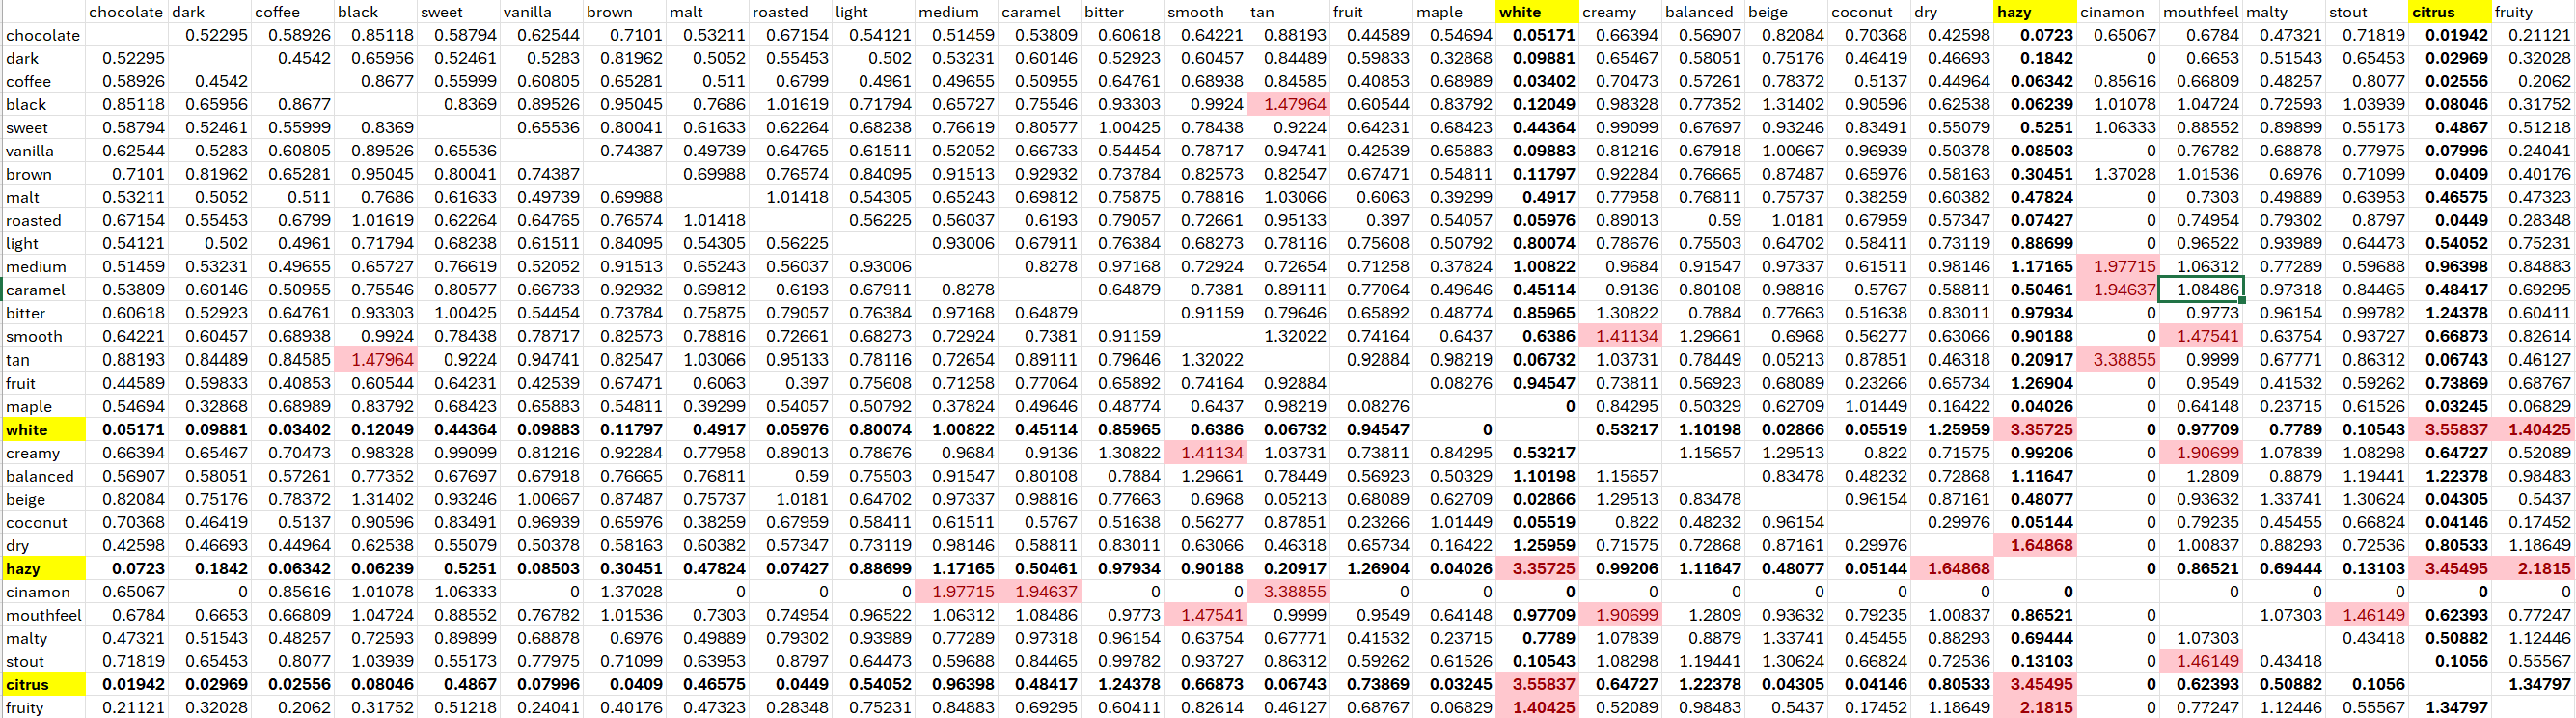

# Getting the 3 main attributes

In [ ]:
#new top attributes
from google.colab import files
uploaded = files.upload()

Saving final_attributes.csv to final_attributes.csv


In [55]:
attributes = pd.read_csv("final_attributes.csv",encoding='cp1252')
attributes

,attributes
0,bitter
1,crisp
2,balanced


In [40]:
attr = ['creamy hazy malty']
attr

['creamy hazy malty']

In [56]:
#add this to the main dataframe
new_row=pd.DataFrame({'product_name': 'attributes' , 'product_review': ' '.join(attributes['attributes'].tolist()) ,'user_rating':5, 'filtered_words': [attributes['attributes'].tolist()]})
#df= pd.concat([new_row, df], ignore_index=True)
#df
new_row

,product_name,product_review,user_rating,filtered_words
0,attributes,bitter crisp balanced,5,"[bitter, crisp, balanced]"


In [57]:
df_new= pd.concat([new_row, df], ignore_index=True)

In [58]:
list_reviews_new = df_new['filtered_words'].tolist()
list_reviews_str = [' '.join(words_list) for words_list in list_reviews_new]
print(list_reviews_str)

['bitter crisp balanced', 'need personal informations companies family friends better life need easy access without noticing contact nick re financially unstable bad credit score solve without stress team clear criminal records without leaving trace also anonymously credit empty credit cards funds need done free obviously like working nick team cause keep updated every step taken order achieve goal also deliver time tested confirmed m still happy life improving encounter send mail premiumhackservices gmail dot com whatsapp 14106350697', 'bottle mbcc 2024 black colour malty aroma wood barrel clear coffee wood taste well really nice', 'thank sharing chris black brown head dark malt aroma wood barrel aroma dark malt body coffee flavours good wood barrel flavours well dark malt coffee wood barrel flavours goes finish real good', 'boxed beer home proper glassware pitch black oily thick pour brown head quickly disappears maple upfront alongside roasted coffee bourbon nose taste beautifully l

# Task C : Cosine Similarity between the first row - with just the attributes and the rest of the rows (normlized)

In [59]:
vectorizer = CountVectorizer()
# Fit and transform the documents
word_matrix = vectorizer.fit_transform(list_reviews_str)
# Convert the matrix to an array
word_matrix_array = word_matrix.toarray()
# Get feature (word) names
feature_names = vectorizer.get_feature_names_out()
# Convert to a DataFrame
df_word_matrix = pd.DataFrame(word_matrix_array, columns=feature_names)
df_word_matrix_normalized = pd.DataFrame(normalize(df_word_matrix, norm='l1', axis=1), columns=feature_names)
df_word_matrix_normalized.head()

,00,000,000th,007,009,00th,01,02,021122,02_december,...,香草和肉桂,香草的量控制的不多不少,香醋和丁香,麦芽,麦芽和谷物的味道压倒了果味,麦芽风味与波本桶味形成平衡,黄苹果,黑巧克力,黑巧克力和干香料味,黑醋栗和葡萄干
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We did translate everything into Enligh - checked the final file but a very few Non Engligh characters came into the picture. These did not effect the results significantly

In [60]:
#cosine similarity
# Calculate cosine similarity of the first row with all rows
cosine_similarities = cosine_similarity(df_word_matrix_normalized.iloc[0:1], df_word_matrix_normalized)

# Convert the result to a DataFrame for better visualization
cosine_similarity_df = pd.DataFrame(cosine_similarities.flatten(), columns=['Cosine Similarity'])

# Display the result
df_new['cosine_sim'] = cosine_similarity_df['Cosine Similarity']
df_new.head()

,product_name,product_review,user_rating,filtered_words,cosine_sim
0,attributes,bitter crisp balanced,5.0,"[bitter, crisp, balanced]",1.000000
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, informations, companies, fami...",0.000000
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, 2024, black, colour, malty, aro...",0.000000
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da...",0.000000
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ...",0.075165


In [61]:
import copy
from copy import deepcopy
df_similarity = copy.deepcopy(df_new.drop(columns = ['user_rating','filtered_words']))
df_similarity.head()

,product_name,product_review,cosine_sim
0,attributes,bitter crisp balanced,1.000000
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",0.000000
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",0.000000
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,0.000000
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",0.075165


In [62]:
task_c =df_similarity[['product_name','product_review','cosine_sim']]
csv_file_path = 'task_c.csv'
# The outout will have the number of times each word had appeared in the product reviews - multiple occuarances within a review is counted as one
task_c.to_csv(csv_file_path, index=False)
#from google.colab import files
#files.download(csv_file_path)

# Task D : Vader similarity

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#sentiment analysis using vader
analyzer = SentimentIntensityAnalyzer()
# Function to calculate sentiment using VADER
def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Apply the VADER sentiment function to the DataFrame
df_new['vader_sentiment'] = df_new['product_review'].apply(vader_sentiment)

# Display the DataFrame with VADER sentiment scores
df_new.head()

,product_name,product_review,user_rating,filtered_words,cosine_sim,vader_sentiment
0,attributes,bitter crisp balanced,5.0,"[bitter, crisp, balanced]",1.000000,-0.4215
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, informations, companies, fami...",0.000000,0.9442
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, 2024, black, colour, malty, aro...",0.000000,0.7955
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da...",0.000000,0.9042
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ...",0.075165,0.9423


# Task E : Overall Evaluation Score

In [64]:
#combine similarity and sentiment scores to get the final score per review - then avergae it out by grouping at a product level
df_new['overall_score']=df_new['cosine_sim']*df_new['vader_sentiment']
df_new.head()

,product_name,product_review,user_rating,filtered_words,cosine_sim,vader_sentiment,overall_score
0,attributes,bitter crisp balanced,5.0,"[bitter, crisp, balanced]",1.000000,-0.4215,-0.421500
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, informations, companies, fami...",0.000000,0.9442,0.000000
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, 2024, black, colour, malty, aro...",0.000000,0.7955,0.000000
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da...",0.000000,0.9042,0.000000
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ...",0.075165,0.9423,0.070828


In [65]:
average_scores = df_new.groupby('product_name')[['overall_score','vader_sentiment','cosine_sim']].mean().sort_values( by = 'overall_score', ascending=False)
average_scores

,overall_score,vader_sentiment,cosine_sim
product_name,,,
Russian River Pliny the Elder,0.040485,0.584169,0.071944
Bell's Expedition Stout,0.033971,0.663638,0.057510
Russian River Pliny the Younger,0.032897,0.661602,0.055018
NÃ¤rke Kaggen Stormaktsporter,0.027869,0.673607,0.037049
Hill Farmstead Abner,0.026924,0.467549,0.058214
Stone Imperial Russian Stout,0.025313,0.494787,0.069626
Bell's Hopslam,0.023355,0.595711,0.042687
Mikkeller Beer Geek Brunch Weasel,0.022621,0.516716,0.044570
NÃ¤rke Konjaks! Stormaktsporter,0.022203,0.541380,0.031960


# Beer Recommendations based on Vader sentiment and Cosine similarity

In [ ]:
# Top 3 beers for the given attributes beased on cosine similarity and vader sentiment analysis
average_scores[:3]

,overall_score,vader_sentiment,cosine_sim
product_name,,,
Hill Farmstead Ann,0.102533,0.673893,0.158700
Hill Farmstead Abner,0.080521,0.467549,0.162280
Russian River Pliny the Elder,0.077168,0.584169,0.129495


For the following beers, the reviews actually mention the words citrus, white or hazy and vader sentiment looks at the average sentiment of the reviews, on a scale of -1 to 1, -1 being most negative and +1 being very positive. A product of these two gives the overall score at a review level, which is then avergaed to get to the final recommendations.

# Task F : Spacy Similarity & Vader sentiment : Comparision with cosine + vader

In [ ]:
#spacy similarity
nlp = spacy.load("en_core_web_md")
# Get the first review
first_review = df_new['product_review'].iloc[0]
# Process the first review
first_doc = nlp(first_review)
# Calculate similarity with all other reviews
similarity_scores = []
# Calculate similarity with all other reviews
for review in df_new['product_review']:
    doc = nlp(review)
    similarity = first_doc.similarity(doc)
    #print(similarity)
    similarity_scores.append(similarity)
# Add similarity scores to the DataFrame
df_new['spacy_similarity'] = similarity_scores

# Display the DataFrame with similarity scores
df_new.head()

,product_name,product_review,user_rating,filtered_words,cosine_sim,vader_sentiment,overall_score,spacy_similarity
0,attributes,citrus white hazy,5.0,"[citrus, white, hazy]",1.0,0.0000,0.0,1.000000
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, informations, companies, fami...",0.0,0.9442,0.0,0.276437
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, 2024, black, colour, malty, aro...",0.0,0.7955,0.0,0.514738
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da...",0.0,0.9042,0.0,0.519545
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ...",0.0,0.9423,0.0,0.481544


In [ ]:
#calculating the overall score based on the vader sentiment and the spacy similarity
df_new['spacy_overall_score']= df_new['spacy_similarity']*df_new['vader_sentiment']
df_new.head()

,product_name,product_review,user_rating,filtered_words,cosine_sim,vader_sentiment,overall_score,spacy_similarity,spacy_overall_score
0,attributes,citrus white hazy,5.0,"[citrus, white, hazy]",1.0,0.0000,0.0,1.000000,0.000000
1,Toppling Goliath Kentucky Brunch,"You need personal informations from companies,...",3.3,"[need, personal, informations, companies, fami...",0.0,0.9442,0.0,0.276437,0.261012
2,Toppling Goliath Kentucky Brunch,"Bottle after MBCC 2024. Black colour, malty ar...",4.5,"[bottle, mbcc, 2024, black, colour, malty, aro...",0.0,0.7955,0.0,0.514738,0.409474
3,Toppling Goliath Kentucky Brunch,Thank you for sharing this Chris - Black with ...,4.3,"[thank, sharing, chris, black, brown, head, da...",0.0,0.9042,0.0,0.519545,0.469773
4,Toppling Goliath Kentucky Brunch,"Boxed beer at home, proper glassware. Pitch bl...",4.7,"[boxed, beer, home, proper, glassware, pitch, ...",0.0,0.9423,0.0,0.481544,0.453759


In [ ]:
average_scores_spacy = df_new.groupby('product_name')['spacy_overall_score'].mean().sort_values(ascending=False)
average_scores_spacy.head()

,spacy_overall_score
product_name,
Three Floyds Dark Lord Russian Imperial Stout,0.354965
Toppling Goliath Mornin' Delight,0.336845
Hill Farmstead Ann,0.336650
Hill Farmstead Aaron,0.333684
Goose Island Bourbon County Stout,0.332309


In [ ]:
# Top 3 Beers based on spacy similarity and vader sentiment
average_scores_spacy[:3]

,spacy_overall_score
product_name,
Three Floyds Dark Lord Russian Imperial Stout,0.354965
Toppling Goliath Mornin' Delight,0.336845
Hill Farmstead Ann,0.336650


### Comparing the Top 3 recommendations based on plain vanilla cosine similarity and spacy similarity:
**a. Using cosine similarity:** <br>
Hill Farmstead Ann :	0.102533 with a cosine similarity of 0.158<br>
Hill Farmstead Abner	: 0.080521 with a cosine similarity of 0.1622<br>
Russian River Pliny the Elder :	0.077168 with a cosine similarity of 0.129<br>


**b.Using spacy similarity:** <br>
Three Floyds Dark Lord Russian Imperial Stout	: 0.354965 (had a cosine similairity and vader score of 0.056 with a cosine similarity of 0.112)  <br>
Toppling Goliath Mornin' Delight	0.336845 <br> (had a cosine similairity and vader score of 0.0 with a cosine similarity of 0.0)
Hill Farmstead Ann	0.336650 (had a cosine similairity and vader score of 0.10 with a cosine similarity of 0.16) <br>


#### We then looked at the web to understand which of these was actually white hazy and citrus, we found the following ranking for these 5 beers:
*1st Place: Hill Farmstead Abner* <br>
*2nd Place: Russian River Pliny the Elder* <br>
*3rd Place: Hill Farmstead Ann* <br>
*4th Place: Three Floyds Dark Lord Russian Imperial Stout* <br>
*5th Place: Toppling Goliath Mornin' Delight* <br>

This shows that in our case, **cosine similarity gave better recommendations!!**

# Task G : Receommendation just on the basis of the average ratings

In [ ]:
# Get the top recommendations just based on average rating
average_rating = df_new.groupby('product_name')['user_rating'].mean().sort_values(ascending=False)
average_rating.head()

,user_rating
product_name,
attributes,5.000000
Toppling Goliath Kentucky Brunch,4.540000
Westvleteren 12,4.422222
Perennial Abraxas - Barrel-Aged,4.377778
Modern Times Monster Tones,4.337778


In [ ]:
average_rating[1:4]

,user_rating
product_name,
Toppling Goliath Kentucky Brunch,4.540000
Westvleteren 12,4.422222
Perennial Abraxas - Barrel-Aged,4.377778


None of these 3 match the recommendations given by cosine or spacy similarity. We digged a little deeper to understand if these beers have anything to do with citrus, white and hazy. These are our findings:

1. Toppling Goliath Kentucky Brunch: This beer is typically classified as a stout, specifically an imperial stout, and does not fall into the citrus, white, or hazy categories.

2. Westvleteren 12: This is a Belgian Quadrupel, also not classified as citrus, white, or hazy. It's known for its rich, complex flavors.

3. Perennial Abraxas - Barrel-Aged: This is a barrel-aged imperial stout with flavors like chocolate, coffee, and spices. It does not fit into the citrus, white, or hazy categories either.

Therefore, if the recommendations are just given on the basis of overall ratings - the customer might not even get a beer of these attributes.

# Task H : Ten Beer Analysis

We chose 10 beers at random and calculated the lift of these beers with respect to all these attributes. These are taken as vectors and used in calculating the cosine similarity between the 10 beers to understand the simialrity between these beers

In [ ]:
#ten beer analysis - we chose 10 beers and did the follwoing analysis to identify the similar beers
from google.colab import files
uploaded = files.upload()

Saving ten_beer.csv to ten_beer.csv


In [ ]:
ten_beer = pd.read_csv("ten_beer.csv", encoding='ISO-8859-1')
ten_beer

,product_name
0,Westvleteren 12
1,Hill Farmstead Aaron
2,AleSmith Speedway Stout
3,Bell's Black Note Stout
4,Modern Times Monster Tones
5,Cigar City Hunahpu's Imperial Stout
6,Funky Buddha Morning Wood
7,Perennial Abraxas - Barrel-Aged
8,Three Floyds Dreadnaught
9,Surly Darkness


In [ ]:
#lift matrix with all the initial attributes
beer_list = ten_beer['product_name'].tolist()
n= len(df_new)
print("total length =",n)
beer_oc = {}
new_at = {'smooth','coffee','vanilla','roasted','malt','hazy','sweet','bitter','cinamon','citrus','fruity'}
at_oc = {}
for i in beer_list:
  beer_oc[i]=len(df_new[df_new['product_name']==i])
  #print(i," ",beer_oc[i])
for i in new_at:
  at_oc[i]= word_count[i]
  #print(i," ",word_count[i])
# Function to count reviews containing the word
def count_reviews_containing_word(df, word):
    count = df['product_review'].str.contains(fr'\b{word}\b', case=False, na=False).sum()
    return count
beer_attribute_lift = pd.DataFrame(np.zeros((len(beer_oc), len(at_oc))), index=beer_oc, columns=at_oc)
for i in beer_list:
  temp_df = df_new[df_new['product_name']==i]
  for j in new_at:
    c=count_reviews_containing_word(temp_df,j)
    #print("Co mentions of ", i,",",i,"=",c)
    lift_value = (n * c) / ( beer_oc[i]* at_oc[j])
    beer_attribute_lift.loc[i, j] = lift_value
    c=0
beer_attribute_lift

total length = 2251


,roasted,cinamon,coffee,vanilla,malt,smooth,sweet,citrus,fruity,hazy,bitter
Westvleteren 12,0.066875,0.000000,0.152275,0.255215,0.645911,0.389784,1.27656,0.248867,0.261896,0.617558,0.534425
Hill Farmstead Aaron,0.000000,0.000000,0.038069,0.816689,0.574143,1.169351,1.27656,0.000000,0.785689,0.617558,0.213770
AleSmith Speedway Stout,0.869370,0.000000,1.446609,0.612517,0.932983,0.909495,0.66192,0.000000,0.000000,0.000000,1.817047
Bell's Black Note Stout,1.003119,0.000000,0.761373,1.276077,0.717679,1.169351,0.94560,0.000000,0.000000,0.000000,0.855081
Modern Times Monster Tones,1.136869,0.000000,0.913648,1.531293,0.789447,0.519711,1.32384,0.000000,0.000000,0.308779,0.320655
Cigar City Hunahpu's Imperial Stout,0.802496,25.011111,0.609099,1.071905,0.861215,1.429206,0.89832,0.000000,0.785689,0.000000,0.641311
Funky Buddha Morning Wood,0.601872,0.000000,1.332403,1.020862,0.574143,0.779567,1.37112,0.000000,0.000000,0.308779,0.641311
Perennial Abraxas - Barrel-Aged,0.735621,0.000000,0.304549,1.429206,0.430607,0.779567,0.56736,0.000000,0.261896,0.000000,0.961966
Three Floyds Dreadnaught,0.000000,0.000000,0.000000,0.000000,1.076518,0.909495,0.47280,4.728469,0.523793,1.852675,1.923932
Surly Darkness,0.735621,0.000000,0.647167,0.255215,0.789447,1.039423,0.70920,0.000000,0.261896,0.000000,0.855081


In [ ]:
# Calculate cosine similarity between all rows
cosine_sim = cosine_similarity(beer_attribute_lift)

In [ ]:
# Convert to DataFrame for easier interpretation
df_cosine_sim = pd.DataFrame(cosine_sim, columns=beer_list, index=beer_list)

# Display the cosine similarity matrix
df_cosine_sim

,Westvleteren 12,Hill Farmstead Aaron,AleSmith Speedway Stout,Bell's Black Note Stout,Modern Times Monster Tones,Cigar City Hunahpu's Imperial Stout,Funky Buddha Morning Wood,Perennial Abraxas - Barrel-Aged,Three Floyds Dreadnaught,Surly Darkness
Westvleteren 12,1.000000,0.854608,0.620192,0.678570,0.708985,0.073051,0.772417,0.611023,0.517141,0.725105
Hill Farmstead Aaron,0.854608,1.000000,0.512806,0.728571,0.707436,0.087962,0.734293,0.707273,0.334964,0.708991
AleSmith Speedway Stout,0.620192,0.512806,1.000000,0.873871,0.743209,0.082408,0.851877,0.806111,0.338928,0.920132
Bell's Black Note Stout,0.678570,0.728571,0.873871,1.000000,0.925505,0.096994,0.920973,0.947371,0.267941,0.910559
Modern Times Monster Tones,0.708985,0.707436,0.743209,0.925505,1.000000,0.087152,0.933520,0.863222,0.205125,0.772411
Cigar City Hunahpu's Imperial Stout,0.073051,0.087962,0.082408,0.096994,0.087152,1.000000,0.087955,0.093168,0.030219,0.095360
Funky Buddha Morning Wood,0.772417,0.734293,0.851877,0.920973,0.933520,0.087955,1.000000,0.816898,0.262206,0.849513
Perennial Abraxas - Barrel-Aged,0.611023,0.707273,0.806111,0.947371,0.863222,0.093168,0.816898,1.000000,0.277177,0.807486
Three Floyds Dreadnaught,0.517141,0.334964,0.338928,0.267941,0.205125,0.030219,0.262206,0.277177,1.000000,0.344623
Surly Darkness,0.725105,0.708991,0.920132,0.910559,0.772411,0.095360,0.849513,0.807486,0.344623,1.000000


In [ ]:
#Looking at the similarity with respect to Bells's Black Note Stout
df_cosine_sim.iloc[:, 3].sort_values(ascending = False)

,Bell's Black Note Stout
Bell's Black Note Stout,1.000000
Perennial Abraxas - Barrel-Aged,0.947371
Modern Times Monster Tones,0.925505
Funky Buddha Morning Wood,0.920973
Surly Darkness,0.910559
AleSmith Speedway Stout,0.873871
Hill Farmstead Aaron,0.728571
Westvleteren 12,0.678570
Three Floyds Dreadnaught,0.267941
Cigar City Hunahpu's Imperial Stout,0.096994


#### Beers most similar to Bells's Black Note Stout:
*   Perennial Abraxas - Barrel-Aged
*   Modern Times Monster Tones
*   Funky Buddha Morning Wood
*   Surly Darkness
*   AleSmith Speedway Stout

#### Beers most dissimilar to Bells's Black Note Stout:

*   Three Floyds Dreadnaught
*   Cigar City Hunahpu's Imperial Stout


